In [1]:
#QUENTIN_GROSHENS_2017#

In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
import time

In [5]:
%matplotlib inline

In [4]:
#first_exercice: counting lines#

In [5]:
def number_lines(filename,N_chunk=10000):
    chunks=pd.read_csv(filename,sep='^',chunksize=N_chunk) #cutting file in chuncks to stay in memory
    n_lines=0
    for chunk in chunks:
        n_lines=n_lines+chunk.shape[0]
    return n_lines

In [6]:
number_lines("searches.csv")

20390198

In [7]:
number_lines("bookings.csv")

10000010

In [8]:
#second_exercice: top arrival airports#

In [29]:
#with the real data#

In [4]:
def topArrivals(N=10,N_chunk=10000):
    chunks=pd.read_csv("bookings.csv",sep='^',chunksize=N_chunk)
    arr_count=pd.DataFrame()#initialize count
    for chunk in chunks:
        local_arr_count=chunk[['arr_port','pax']]
        local_arr_count=local_arr_count.dropna(axis=0, how='any')#drop rows with Nans
        local_arr_count=local_arr_count.groupby('arr_port').aggregate(sum)#sum by arrival airport
        arr_count=arr_count.add(local_arr_count,fill_value=0).astype(int)
    arr_count=arr_count.sort_values(by='pax',ascending=False )[:N] 
    return arr_count
    

In [7]:
arr_count=topArrivals(10,N_chunk=10000)

In [15]:
arr_count

,pax
arr_port,
LHR,88809
MCO,70930
LAX,70530
LAS,69630
JFK,66270
CDG,64490
BKK,59460
MIA,58150
SFO,58000


In [9]:
arr_count.to_json("topArrivals.json")


In [125]:
#third exercice: monthly destination searches#
#first one destination at a time#

In [10]:
months_string=['January','February','March','April','May','June','July','August','September','October','November','December']


In [11]:
def date2month(date):
    #input string as a date eg: 'yyyy-mm-dd'
    #output string as a month eg: 'March'
    month=int(date.split('-')[1])-1 #january=0 ect#
    return months_string[month]

In [19]:
def monthlySearches(destination,N_chunk=10000):
    monthly_search=pd.DataFrame(np.zeros((12,1),dtype=int),columns=[destination],index=months_string)  #initialize a dataframe indexed on months for counting
    chunks=pd.read_csv("searches.csv",sep='^',chunksize=N_chunk)
    for chunk in chunks:
        date_df=chunk[chunk['Destination']== destination]['Date'].apply(date2month)#transform the date date as just the month for the entries matching the destination
        local_monthly=date_df.value_counts()#counting by month
        monthly_search=monthly_search.add(pd.DataFrame(local_monthly.values,local_monthly.keys().values,columns=[destination]),fill_value=0).astype(int)#transform the data from local_monthly to a proper dataframe and adding  
    monthly_search.index=pd.CategoricalIndex(months_string,categories=months_string,sorted=True)#properly order the months in the dataframe  
    return monthly_search.sort_index()

In [13]:
def multiMonthlySearches(destinations,N_chunk=10000):
    msTotal=pd.DataFrame()
    for destination in destinations:
        msTotal=pd.concat([msTotal,monthlySearches(destination,N_chunk=N_chunk)],axis=1)
    return msTotal

In [14]:
msTotal=multiMonthlySearches(['AGP','MAD','BCN'])

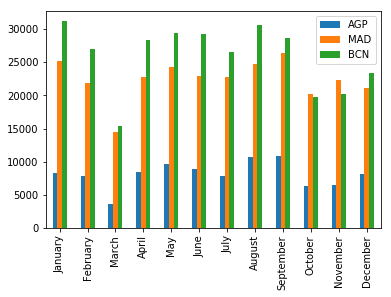

In [17]:
msTotal.plot(kind='bar')

In [6]:
#fourth exercice: matching seaches and bookings#


In [9]:
daySec=24*60*60


In [10]:
def getDate(timeString):
    return timeString.split(" ")[0]
    
    

In [11]:
def stripString(string):
    copy=string
    return copy.strip()

In [12]:
def stringToTime(stringTime):
    #parse a string and return the number of second since the ref time date
    return time.mktime(time.strptime(stringTime,'%Y-%m-%d %H:%M:%S'))

In [13]:
def getTime(entry):
    #build the string combining the date and the time and return the seconds
    
    #stringTime=entry['Date']+' '+entry['Time']
    
    
    return time.mktime(time.strptime(entry['Seg1Date'],'%Y-%m-%d'))
    #return stringToTime(stringTime)
    

In [14]:
def isInTimeframe(act_date,referenceTime,timeframe=daySec):
    #check if a time is within a given timeframe from a ref date
    timeStamp=stringToTime(act_date)-referenceTime
    return (timeStamp<=timeframe)&(timeStamp>0)


In [15]:
def isAfterTimeframe(act_date,referenceTime,timeframe=daySec):
    #check if a time is after a given timeframe from a ref date
    timeStamp=stringToTime(act_date)-referenceTime
    return (timeStamp>timeframe)

In [16]:
def isMatchingArrDep(booking,search):
    #check if destination and departure are matching   
    return (booking['arr_port'].strip()==search['Destination'])&(booking['dep_port'].strip()==search['Origin'])

In [17]:
def fullMatching(booking,search,timeframe=daySec):
    #combine the time and location matching between a booking and a search
    matchArrDep=isMatchingArrDep(booking,search)
    #matchTime=isInTimeframe(booking['act_date           '],getTime(search),timeframe)
    
    matchTime=time.strptime(booking['off_time           '].split(" ")[0],'%Y-%m-%d')==time.strptime(search['Seg1Date'],'%Y-%m-%d')
    return matchArrDep#&matchTime
    

In [28]:
def searchToBooking(search,N_chunk=10000):
    #doesn't take into account if the booking was canceled after
    #doesn't perfectly take into account multiple search and or multiple bookings within the timeframe
    #return 1 if a booking with matching arrival and departure is found within the timeframe and if the booking was not canceled within the timeframe
    #return 0 otherwise
    #timeframe 24h
    
    if not(isinstance(search['Seg1Date'],str)):
        return 0
    
    referenceTime=getTime(search)
    timeframe=daySec
    bookingCount=0
    
    chunks=pd.read_csv("bookings.csv",sep='^',chunksize=N_chunk)
    for chunk in chunks:
        #local_bookings=chunk[['act_date           ','arr_port','dep_port','pax']]
        local_bookings=chunk[['off_time           ','arr_port','dep_port','pax']]
        #if isAfterTimeframe(local_bookings.head(1)['off_time           '].values[0],referenceTime,timeframe):
        #    return 0 #if the head is after the timeframe, all following bookings are out of the timeframe
        
        #local_bookings=local_bookings[local_bookings.apply(fullMatching,search=search,timeframe=timeframe,axis=1).values]#filter the matching bookings
        
        #separated matching for testing
        timeCond=local_bookings['off_time           '].apply(getDate)==search['Seg1Date']
        
        local_bookings=local_bookings[timeCond]
        if local_bookings.shape[0]==0:
            continue         
        #local_bookings['arr_port']=local_bookings['arr_port'].apply(stripString)
        #local_bookings['dep_port']=local_bookings['dep_port'].apply(stripString)        
        
        local_bookings=local_bookings[local_bookings['arr_port'].apply(stripString)==search['Destination']]      
        if local_bookings.shape[0]==0:
            continue
        local_bookings=local_bookings[local_bookings['dep_port'].apply(stripString)==search['Origin']]
        if local_bookings.shape[0]==0:
            continue
       
        print('location match ' )  
        print(local_bookings.shape)   
        
        print(local_bookings)
        print(search[['Destination','Origin','Seg1Date']])
        

   
        
        
        local_bookings=local_bookings.dropna(axis=0, how='any')
        if local_bookings.shape[0]==0:
            continue #no booking match in this chunck, cheack next chunk
        bookingCount=bookingCount+local_bookings['pax'].aggregate(sum)#if all matching booking are canceled during the timeframe, sum will be 0
    if bookingCount>0:
        return 1
    else:
        return 0 #all chunk are chek with no success

        


In [29]:
def matchSearchBooking(N_chunk=10):
    chunks=pd.read_csv("searches.csv",sep='^',chunksize=N_chunk,nrows=1000)
    header=True
    for chunk in chunks:
        chunk['Booking']=chunk.apply(searchToBooking,axis=1)
        chunk.to_csv("seachMatch.csv",mode='a',header=header)#append to seachMatch. be carefull if the file is already existing
        if header:#put the header only with the first write
            header=False
    
    

In [ ]:
matchSearchBooking()